In [1]:
try:
    import torch
except:
    !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
    import torch

# RealNVP Network
Arxiv link: https://arxiv.org/abs/1605.08803

In [2]:
import numpy as np

class RealNVP(torch.nn.Module):
    '''
    A Pytorch implement of RealNVP Network.
    
    Args:
        num_vars(int): length of inputs.
        num_layers(int): number of RealNVP layers.
        hidden_s(int): number of hidden units of in each s layer.
        hidden_t(int): number of hidden units of in each t layer.
       
    Attributes:
        num_vars(int): length of inputs.
        num_layers(int): number of RealNVP layers.
        scale(nn.ModuleList): list of scale layers.
        translation(nn.ModuleList): list of translation layers.
    '''
    def __init__(self, num_vars, num_layers=2, hidden_s=10, hidden_t=10):
        super(RealNVP, self).__init__()
        self.num_vars = num_vars
        self.num_layers = num_layers

        self.scale = torch.nn.ModuleList()
        self.translation = torch.nn.ModuleList()
        for i in range(self.num_layers):
            if i != self.num_layers-1: # last layer of scale we use has a Tanh() activation to avoid exp() blowing up. 
                self.scale.append(
                     torch.nn.Sequential(
                     torch.nn.Linear(num_vars//2, hidden_s),
                     torch.nn.ReLU(),
                     torch.nn.Linear(hidden_s, num_vars//2)
                     ))
            else:
                self.scale.append(
                    torch.nn.Sequential(
                    torch.nn.Linear(num_vars//2, hidden_s),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_s, num_vars//2),
                    torch.nn.Tanh()
                    ))
            self.translation.append(
                 torch.nn.Sequential(
                 torch.nn.Linear(num_vars//2, hidden_t),
                 torch.nn.ReLU(),
                 torch.nn.Linear(hidden_t, num_vars//2)
                 ))

    def forward(self, z):
        '''
        Generate complex distribution from z sampled from gaussian distribution.
        '''
        y0 = z[:,:self.num_vars//2]
        y1 = z[:,self.num_vars//2:]
        self.logjac = z.new_zeros(z.shape[0]) # create Variable to store log(jacobian).
        for i in range(self.num_layers):
            if (i%2==0):
                y1 = y1 * torch.exp(self.scale[i](y0))  + self.translation[i](y0)
                self.logjac += self.scale[i](y0).sum(dim=1) # calculate log(jacobian).
            else:
                y0 = y0 * torch.exp(self.scale[i](y1)) +  self.translation[i](y1)
                self.logjac += self.scale[i](y1).sum(dim=1)
        return torch.cat((y0, y1), 1)

    def inverse(self, x):
        '''
        Inference gaussian distribution from x sampled from complex distribution.
        '''
        y0 = x[:,:num_vars//2]
        y1 = x[:,num_vars//2:]
        self.logjac = x.new_zeros(x.shape[0]) # create Variable to store log(jacobian).
        for i in reversed(range(self.num_layers)):
            if (i%2==1):
                y0 = (y0 - self.translation[i](y1)) * torch.exp(-self.scale[i](y1))
                self.logjac -= self.scale[i](y1).sum(dim=1) # calculate log(jacobian)
            else:
                y1 = (y1 - self.translation[i](y0)) * torch.exp(-self.scale[i](y0))
                self.logjac -= self.scale[i](y0).sum(dim=1)
        return torch.cat((y0, y1), 1)

    def logp(self, x):
        '''
        Calculate x's log(probability).
        '''
        z = self.inverse(x)
        return -0.5*(z**2).sum(dim=1) + self.logjac # add accumulated log(jacobian) to gaussian distribution.

## Bijective Check

(New line of test added to check if $Log(Jacobian)$ is equal between generate and inference process.)

In [3]:
num_vars = 4 
model = RealNVP(num_vars) 
z = torch.randn(1000,num_vars)

x = model.forward(z) # generate a new dataset.
x_logjac = model.logjac # record log(Jacobian) in generate process.

z_infer = model.inverse(x) # inference back to the original dataset.
z_infer_logjac = model.logjac # record log(Jacobian) in inference process.

from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(z_infer.detach().numpy(),z.detach().numpy()) # test if they are the same.
assert_array_almost_equal(x_logjac.detach().numpy(),-z_infer_logjac.detach().numpy()) # abs(log(Jacobian)) should be same.

## Training Network

--2018-05-07 17:37:19--  https://pastebin.com/raw/JWgv53pd
正在解析主机 pastebin.com (pastebin.com)... 104.20.208.21, 104.20.209.21
正在连接 pastebin.com (pastebin.com)|104.20.208.21|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：未指定 [text/plain]
正在保存至: “train.dat”

train.dat               [ <=>                ] 180.85K  --.-KB/s  用时 0.1s      

2018-05-07 17:37:20 (1.21 MB/s) - “train.dat” 已保存 [185188]



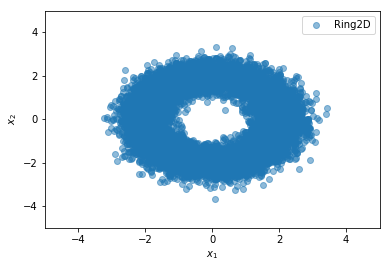

In [4]:
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

!wget https://pastebin.com/raw/JWgv53pd -O train.dat # download and load training data.
  
xy = np.loadtxt('./train.dat', dtype=np.float32) 
x_data = torch.from_numpy(xy).to(torch.float32)
num_vars = x_data.shape[-1]

plt.figure() # plot training date.
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='Ring2D')
plt.legend()

plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
plt.ylim([-5, 5])

plt.xlabel('$x_1$') # label axes.
plt.ylabel('$x_2$')

plt.show()

In [5]:
torch.manual_seed(10086)

num_epochs = 800 # define parameters of RealNVP network.
num_layers = 4
hidden_t = 10
hidden_s = 10
num_samples = 2000

model = RealNVP(num_vars, num_layers,hidden_s,hidden_t) # define RealNVP instance and optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

epoch: 0 loss: 4.805755138397217
epoch: 50 loss: 1.6548107862472534
epoch: 100 loss: 1.4469808340072632
epoch: 150 loss: 1.399949312210083
epoch: 200 loss: 1.3778932094573975
epoch: 250 loss: 1.3630415201187134
epoch: 300 loss: 1.3390930891036987
epoch: 350 loss: 1.3238091468811035
epoch: 400 loss: 1.3112956285476685
epoch: 450 loss: 1.3000178337097168
epoch: 500 loss: 1.2997483015060425
epoch: 550 loss: 1.2843025922775269
epoch: 600 loss: 1.2785871028900146
epoch: 650 loss: 1.2780630588531494
epoch: 700 loss: 1.2811592817306519
epoch: 750 loss: 1.2690441608428955
epoch: 800 loss: 1.2660818099975586


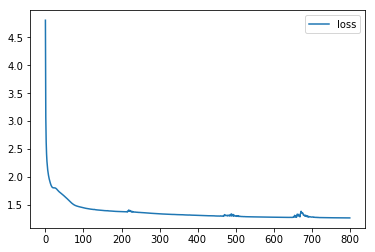

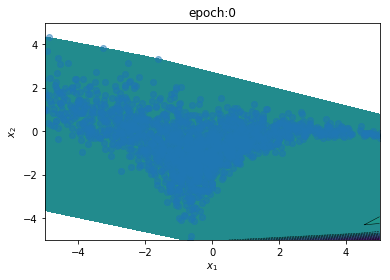

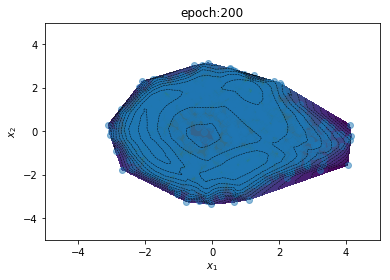

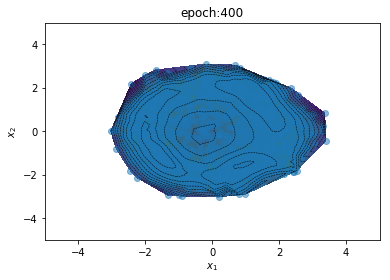

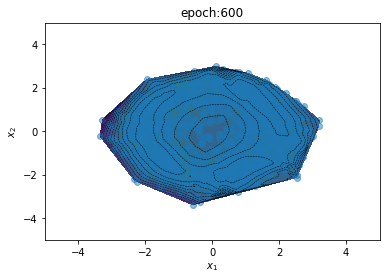

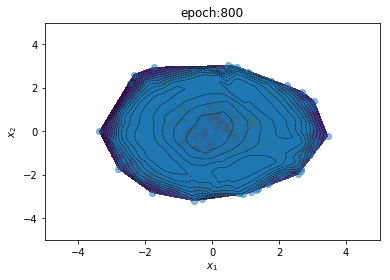

In [6]:
L = [] # L will be a list of losses for plotting.

f = plt.figure() # create a figure and an axis to plot loss curve.
ax = f.add_subplot(1,1,1)

xi = np.linspace(-5, 5, num_samples) # generate xi yi for mesh grid.
yi = np.linspace(-5, 5, num_samples)

for epoch in range(num_epochs+1):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    logp = model.logp(x_data)
    loss = -logp.mean() # get NLL loss for training.
    
    if epoch%50 == 0:
      print("epoch:",epoch,"loss:",loss.item())
      
    if epoch%200 == 0:
      
      ft = plt.figure() # create a figure and an axis to plot generated sample points.
      axt = ft.add_subplot(1,1,1)
      axt.set_title("epoch:%g"%(epoch))
      
      z = torch.randn(num_samples, num_vars)
      x = model.forward(z)
      logp = model.logp(x) # get log(probability) of each sampled point.
      
      zi = griddata(x[:,0].detach().numpy(), x[:,1].detach().numpy(), logp.detach().numpy(), xi, yi, interp='linear')
      plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
      plt.contourf(xi, yi, zi, 15,vmax=abs(zi).max(), vmin=-abs(zi).max())
      axt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), alpha=0.5, label='generated') # generated mesh data and plot contour.
      
      plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
      plt.ylim([-5, 5])

      plt.xlabel('$x_1$') # label axes.
      plt.ylabel('$x_2$')
      
    L.append(loss.detach().numpy()) # at each epoch add new loss to L
    
    optimizer.zero_grad() # do the training of model's parameters.
    loss.backward()
    optimizer.step()
    
ax.plot(range(len(L)),np.array(L),label = 'loss') # plot the loss curve.
ax.legend()

plt.show()

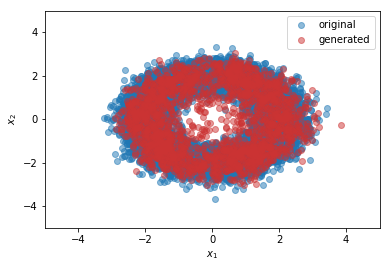

In [7]:
z = torch.randn(num_samples, num_vars) # create a random dataset to perform testing.
x = model.forward(z)

plt.figure() # plot training data along with generated data.
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='original')
plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), alpha=0.5, label='generated',c='#CC3333')
plt.legend()

plt.xlim([-5, 5]) # limit x and y axes between [-5,5] for better viewing.
plt.ylim([-5, 5])

plt.xlabel('$x_1$') # label axes.
plt.ylabel('$x_2$')

plt.show()

# More reference:
1. https://blog.evjang.com/2018/01/nf1.html
2. https://blog.evjang.com/2018/01/nf2.html